## Setup

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
PROJECT = 'pokoyakazan-test-01'
BUCKET = 'pokoyakazan-test-01'
REGION = 'us-central1'

os.environ['BUCKET'] = BUCKET

## Exploration using Spark SQL of Dataproc
- 以下の分析はBQでもできるが今回はSpark SQLをGCSから読み込んで使ってみる

### Start a SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bays classification using Spark") \
    .getOrCreate()

### flightsデータ読み込み

#### Sparkで読み込むためのSchemaを定義

In [3]:
# Set up schema to read in the CSV files on GCS
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
  if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
    return StructField(colname, FloatType(), True)
  else:
    return StructField(colname, StringType(), True)
  
schema = StructType([get_structfield(colname) for colname in header.split(',')])
print(schema)

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

-> ARR_DELAY', 'DEP_DELAY', 'DISTANCE'以外はStringTypeになっている

#### SchemaとGCS上のcsvのPathを指定してflightsデータを読み込む

In [4]:
# Create a table definition (this is done lazily; the files won't be read until we issue a query)
#inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET)
inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)
flights_csv = spark.read\
            .schema(schema)\
            .csv(inputs)

#### 読み込んだデータからTempView作成

In [5]:
flights_csv.createOrReplaceTempView('flights_tmp')

In [6]:
# check
results = spark.sql('SELECT COUNT(*) FROM flights_tmp WHERE dep_delay > -20 AND distance < 2000')
results.show()
results = spark.sql('SELECT * FROM flights_tmp WHERE dep_delay > -20 AND distance < 2000')
results.head(1)

+--------+
|count(1)|
+--------+
| 5762824|
+--------+



[Row(FL_DATE='2015-03-01', UNIQUE_CARRIER='AA', AIRLINE_ID='19805', CARRIER='AA', FL_NUM='17', ORIGIN_AIRPORT_ID='10397', ORIGIN_AIRPORT_SEQ_ID='1039705', ORIGIN_CITY_MARKET_ID='30397', ORIGIN='ATL', DEST_AIRPORT_ID='13303', DEST_AIRPORT_SEQ_ID='1330303', DEST_CITY_MARKET_ID='32467', DEST='MIA', CRS_DEP_TIME='2015-03-01 12:00:00', DEP_TIME='2015-03-01 12:31:00', DEP_DELAY=31.0, TAXI_OUT='10.00', WHEELS_OFF='2015-03-01 12:41:00', WHEELS_ON='2015-03-01 14:03:00', TAXI_IN='6.00', CRS_ARR_TIME='2015-03-01 13:52:00', ARR_TIME='2015-03-01 14:09:00', ARR_DELAY=17.0, CANCELLED='0.00', CANCELLATION_CODE=None, DIVERTED='0.00', DISTANCE=594.0, DEP_AIRPORT_LAT='33.63666667', DEP_AIRPORT_LON='-84.42777778', DEP_AIRPORT_TZOFFSET='-18000.0', ARR_AIRPORT_LAT='25.79527778', ARR_AIRPORT_LON='-80.29000000', ARR_AIRPORT_TZOFFSET='-18000.0', EVENT=None, NOTIFY_TIME=None)]

### train_dayデータ読み込み

trainday.csvは小さいデータなのでspark側にカラムごとの型を推測(inferSchema)させる
- また、最初の一行が絡む名なのでheaderをtrue

In [7]:
inputs = 'gs://{}/flights/trainday.csv'.format(BUCKET)
traindays = spark.read \
  .option("header", "true")\
  .option("inferSchema", "true")\
  .csv(inputs)
traindays.createOrReplaceTempView('traindays_tmp')

In [8]:
# check
results = spark.sql('select * from traindays_tmp')
results.head(5)

[Row(FL_DATE=datetime.datetime(2015, 1, 1, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 4, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 5, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 7, 0, 0), is_train_day=True),
 Row(FL_DATE=datetime.datetime(2015, 1, 8, 0, 0), is_train_day=True)]

### Make train data

In [9]:
statement = """
select
 f.FL_DATE AS date,
 distance,
 dep_delay
from flights_tmp f
join traindays_tmp t
on f.FL_DATE==t.FL_DATE
where t.is_train_day
and f.dep_delay is not null
order by f.dep_delay desc
"""
train_flights = spark.sql(statement)

#### トレーニングデータの統計情報確認

"件数"、"フライト距離、出発遅延それぞれの最大値、平均、最小値"など

In [10]:
# plotするためにsparkデータフレームをpandasデータフレームに変換
df = train_flights[(train_flights['distance'] < 2000)
                   & (train_flights['dep_delay'] > -20)
                   & (train_flights['dep_delay'] < 30)]
df.describe().show()

+-------+----------+------------------+--------------------+
|summary|      date|          distance|           dep_delay|
+-------+----------+------------------+--------------------+
|  count|   3638261|           3638261|             3638261|
|   mean|      null| 711.8030575596418|-0.21208896228170546|
| stddev|      null|442.63295949480585|   8.226719283838538|
|    min|2015-01-01|              31.0|               -19.0|
|    max|2016-01-31|            1999.0|                29.0|
+-------+----------+------------------+--------------------+



Hexbin plot で分布確認
- フライト距離は250~500に集中
- 出発遅延時間は-5~0に集中

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


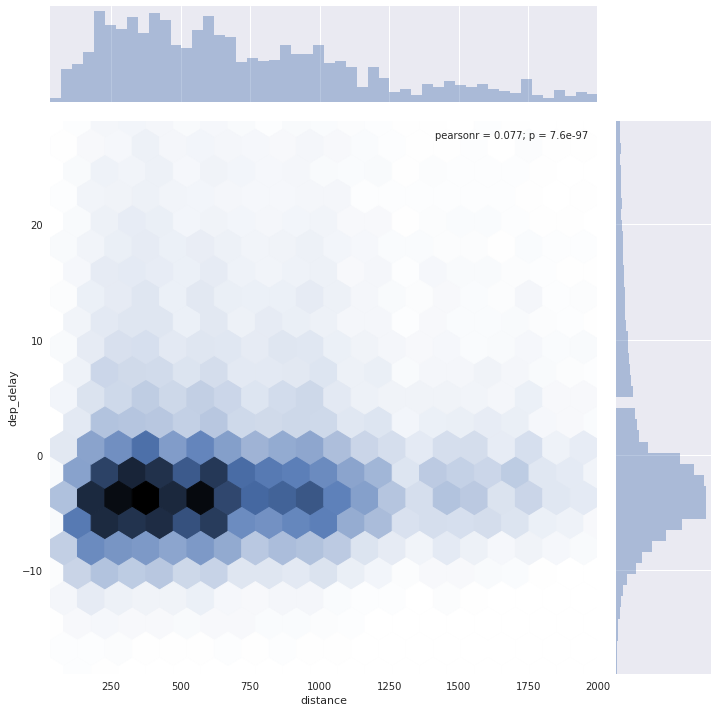

In [11]:
# dfから2%をサンプリングする
pdf = df.sample(False, 0.02, 20).toPandas() # to 100,000 rows approx on complete dataset
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex",
                  size=10, joint_kws={'gridsize':20})

## ヒストブラムイコライゼーション

### データを均一に分ける境界値を見つける
近似分位法を行ってデータ数が同じになるように間隔をきる
- APPROX_QUANTILES
  - BigQueryで近似分位法を行う関数
- **approxQuantile** -> **今回はこっちを使用**
  - sparkで近似分位法を行う関数

In [12]:
# フライト距離の境界値
distthresh = train_flights.approxQuantile('distance', list(np.arange(0, 1.0, 0.1)), 0.02)
distthresh # 最初の値は最小値

[31.0, 248.0, 370.0, 474.0, 583.0, 689.0, 844.0, 992.0, 1562.0, 1744.0]

In [13]:
# 出発遅延の境界値
delaythresh = train_flights.approxQuantile('dep_delay', list(np.arange(0, 1.0, 0.1)), 0.05)
delaythresh # 最初の値は最小値

[-82.0, -8.0, -6.0, -5.0, -3.0, -1.0, 0.0, 9.0, 19.0, 52.0]

すべてのフライトのおよそ1/10は1.0分から3.0分の出発遅延時間を持つ

-> **出発遅延時間が17分以上 かつ フライト距離が2419マイル以上のフライトは全体の1/100**

In [14]:
results = spark.sql('SELECT COUNT(*) FROM flights_tmp WHERE dep_delay >= 17 AND distance >= 2419')
results.show()

+--------+
|count(1)|
+--------+
|   36844|
+--------+



## 各セルにおいて時間通りに到着するフライトが70%以上かどうかを計算
これ以降の計算はSparkでも可能だが、ここではPigを使う